In [1]:
import os
from tqdm.notebook import tqdm
import guitarpro
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np

import pandas as pd
from collections import Counter

from src.models.vae import MusicVAE
from src.parse_gp import drop_rests_from_drum_track, get_notes_and_durations
from src.save_midi import save_notes_and_durations

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = [], []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        tab_notes, tab_durations = get_notes_and_durations(tab, track_name, True)
        notes += tab_notes
        durations += tab_durations

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

<BarContainer object of 526 artists>

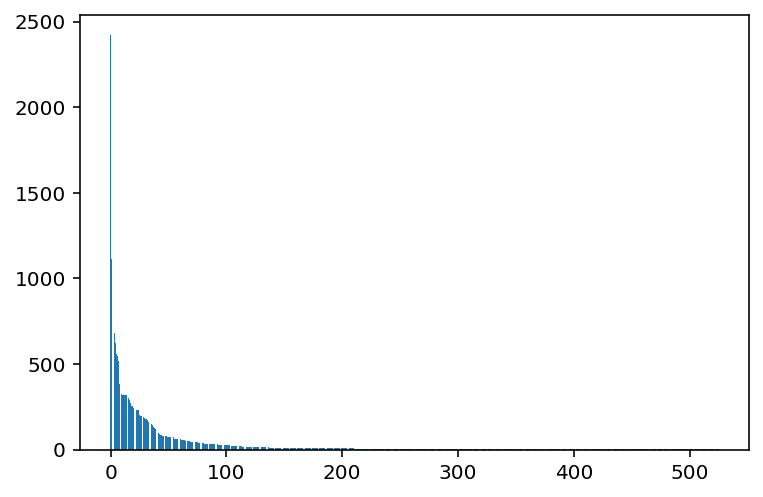

In [4]:
note_counts = Counter(notes)
df = pd.DataFrame(note_counts.items(), columns=['note', 'cnt']).sort_values('cnt', ascending=False)
plt.bar(range(df.shape[0]), df.cnt)

In [5]:
limit = 150
note_to_use = df.iloc[:limit].note.values

In [6]:
notes_corr, durations_corr = [], []
for note, dur in zip(notes, durations):
    if note in note_to_use:
        notes_corr.append(note)
        durations_corr.append(dur)

In [7]:
note_dictionary = {note: i for i, note in enumerate(note_to_use)}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes_corr]
notes_to_int[:10]

[22, 3, 3, 0, 3, 3, 3, 5, 3, 0]

In [8]:
duration_dictionary = {dur: i for i, dur in enumerate(set(durations_corr))}
inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
durations_to_int = [duration_dictionary[dur] for dur in durations_corr]
durations_to_int[:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
def prepare_sequences(notes, durations, length, step, n_notes, n_durations):
    batch_size = 32
    note_sequences = []
    dur_sequences = []
    for i in range(0, len(notes) - length, step):
        note_sequences.append(notes[i: i + length])
        dur_sequences.append(durations[i: i + length])
    
    note_sequences = np.array(note_sequences)
    dur_sequences = np.array(dur_sequences)
    
    length = (len(note_sequences) // batch_size) * batch_size
    indicies = np.arange(length)
    np.random.shuffle(indicies)
    
    note_targets = to_categorical(note_sequences[indicies], n_notes)    
    dur_targets = to_categorical(dur_sequences[indicies], n_durations)
    sequences = [note_sequences[indicies], dur_sequences[indicies]]
    targets = [note_targets, dur_targets]
    return sequences, targets

In [10]:
X, y = prepare_sequences(notes_to_int, durations_to_int, 128, 1, len(note_dictionary), len(duration_dictionary))
X[0].shape

(18432, 128)

In [11]:
y[0].shape

(18432, 128, 150)

In [12]:
model = MusicVAE(
    kernel_size = 32,
    encoder_filters = [64, 32, 16, 8],
    encoder_strides = [1, 2, 2, 1],
    decoder_filters = [8, 16, 32, 64],
    decoder_strides = [1, 2, 2, 1],
    n_notes = len(note_dictionary),
    n_durations = len(duration_dictionary),
    emb_size = 32,
    input_dim = X[0].shape[1],
    latent_dim = 2,
    loss_factor = 500
)

In [13]:
model.compile(0.0005)

In [14]:
model.model.fit(
    X, y,
    shuffle=True,
    batch_size=32,
    epochs=20
)

Epoch 1/20
576/576 [==============================] - 24s 40ms/step - cce_notes: 2039.0278 - cce_durations: 672.9116 - kl: 7.8678 - loss: 2719.8071
Epoch 2/20
576/576 [==============================] - 23s 40ms/step - cce_notes: 1861.3621 - cce_durations: 599.0611 - kl: 7.3102 - loss: 2467.7332
Epoch 3/20
576/576 [==============================] - 21s 37ms/step - cce_notes: 1789.5075 - cce_durations: 602.5409 - kl: 7.7311 - loss: 2399.7798
Epoch 4/20
576/576 [==============================] - 23s 40ms/step - cce_notes: 1732.1118 - cce_durations: 599.1232 - kl: 8.1498 - loss: 2339.3850
Epoch 5/20
576/576 [==============================] - 22s 39ms/step - cce_notes: 1694.6351 - cce_durations: 594.0834 - kl: 8.3886 - loss: 2297.1072
Epoch 6/20
576/576 [==============================] - 22s 39ms/step - cce_notes: 1664.0073 - cce_durations: 591.1787 - kl: 8.4774 - loss: 2263.6631
Epoch 7/20
576/576 [==============================] - 22s 39ms/step - cce_notes: 1639.3178 - cce_durations: 589.

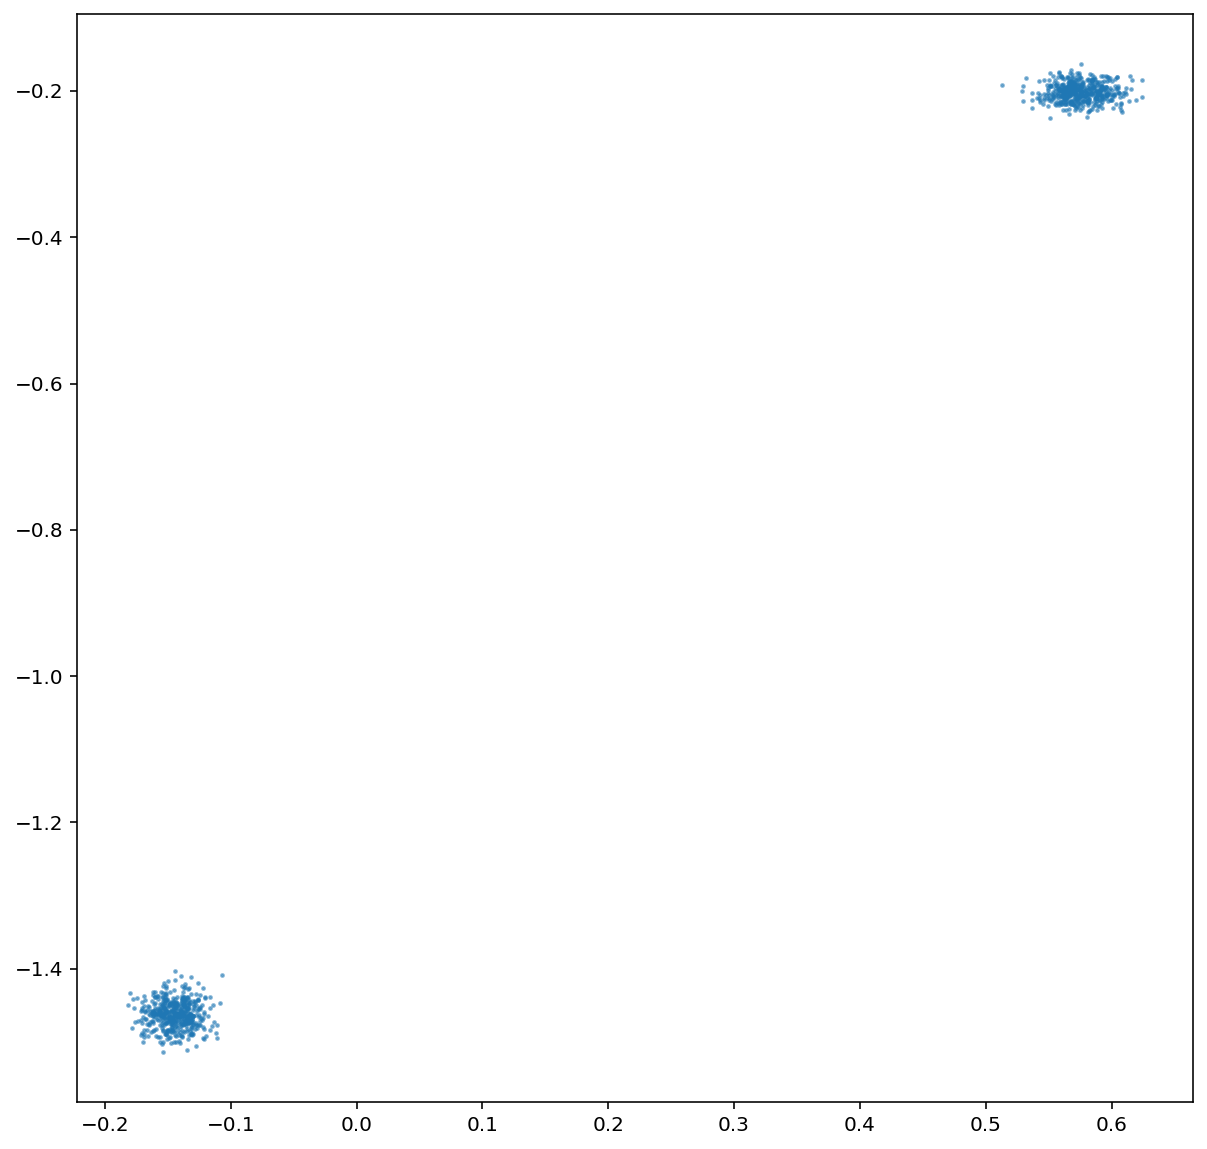

In [15]:
example_idx = np.random.choice(range(len(X)), 1000)
example_states = [X[0][example_idx], X[1][example_idx]]

_, _, z_points = model.encoder.predict(example_states)

plt.figure(figsize=(10, 10))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , alpha=0.5, s=2)
plt.show()

In [16]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [18]:
temperatures = [0.0, 0.5, 0.9]

for temperature in temperatures:
    generated_notes = []
    generated_durations = []
    predicted_notes, predicted_durations = model.decoder.predict(np.array([[-0.15, -1.45]]))
    for i in range(predicted_notes.shape[1]):
        generated_notes.append(sample(predicted_notes[0][i], temperature))
        generated_durations.append(sample(predicted_durations[0][i], temperature))
        
    generated = [[inv_note_dictionary[x] for x in generated_notes], [inv_dur_dictionary[x] for x in generated_durations]]
    save_notes_and_durations(generated, f'output/vae_upsample/output_{temperature}_down')